In [2]:
import pandas_market_calendars as mcal
import pandas as pd
import random 
import numpy as np
import os

# 创建 NYSE 日历
nyse = mcal.get_calendar("NYSE")

# 生成交易日（例如 1990 到 2030）
schedule = nyse.schedule(start_date="1990-01-01", end_date="2030-12-31")

# 得到实际交易日数组
#nyse_dates = schedule.index.tz_localize(None).normalize()

nyse_dates = mcal.date_range(schedule, frequency="1D").normalize()
nyse_dates = nyse_dates.tz_localize(None)
trading_days = mcal.date_range(schedule, frequency='1D').normalize().tz_localize(None)


In [2]:
nyse_dates

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2030-12-17', '2030-12-18', '2030-12-19', '2030-12-20',
               '2030-12-23', '2030-12-24', '2030-12-26', '2030-12-27',
               '2030-12-30', '2030-12-31'],
              dtype='datetime64[ns]', length=10322, freq=None)

In [3]:
import warnings, logging
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Glyph .* missing from font", category=UserWarning)
def no_path_warning_format(message, category, filename, lineno, line=None):
    return f"{category.__name__}: {message}\n"

warnings.formatwarning = no_path_warning_format
logging.getLogger().setLevel(logging.ERROR)
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False     

In [4]:
import sys
import os

# 获取当前 Notebook 的绝对路径
current_dir = os.getcwd()

# 假设 src 在上一级目录 (即 c:\LLM-study\FinRL-Trading-refactor)
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# 将项目根目录添加到 sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root added to path: {project_root}")

Project root added to path: c:\LLM-study\FinRL-Trading-refactor


In [5]:
from src.strategies.strategylogger import StrategyLogger ,AsyncWriterThread
from src.strategies.base_signal import BaseSignalEngine
from src.strategies.universe_manager import UniverseManager
from src.strategies.execution_engine import ExecutionManager
from src.strategies.KamaTrendSignalEngine import KamaTrendSignalEngine
from src.strategies.tsmomsignal import TSMOMSignalEngine


### Strategy Logger

###  UniverseManager

### ExecutionManager

# base signaling 

#KamaTrendSignalEngine

In [6]:
stock_selected = pd.read_csv(
    "./data/alpaca/lxy2_stock_selected.csv",
    parse_dates=["trade_date"]
)
stock_selected.head()
stock_selected["trade_date"] = stock_selected["trade_date"].dt.tz_localize(None)


In [7]:
col_map = {
    "tic_name": "tic",           # 内部 tic_name 对应文件中的 tic 字段
    "trade_date": "trade_date",  # 内部 trade_date 对应文件中的 trade_date 字段
}

In [15]:
nyse_dates

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2030-12-17', '2030-12-18', '2030-12-19', '2030-12-20',
               '2030-12-23', '2030-12-24', '2030-12-26', '2030-12-27',
               '2030-12-30', '2030-12-31'],
              dtype='datetime64[ns]', length=10322, freq=None)

In [8]:
logger = StrategyLogger("KamaTrendSignalEngine")

uni_mgr = UniverseManager(
    stock_selection_df=stock_selected,
    col_map=col_map,
    trading_calendar=nyse_dates,
    logger=logger ,    # 或者放入你自己的 logger
    backtest_start="2020-03-01",
    backtest_end= None


)

uni_mgr.universe_df.head(20)


,date,tic_name,in_universe
0,2020-03-03,AAPL,1
1,2020-03-03,AMD,1
2,2020-03-03,AMZN,1
3,2020-03-03,AVGO,1
4,2020-03-03,BABA,1
5,2020-03-03,COIN,1
6,2020-03-03,COST,1
7,2020-03-03,CRCL,1
8,2020-03-03,CRM,1
9,2020-03-03,FCX,1


signal_df ： 

date	AAPL	MSFT	AMZN	…
2020-01-02	1	0	-1	…
2020-01-03	0	1	0	…
2020-01-06	-1	0	1	…

In [9]:
# 从 universe 提取全部股票列表
all_tics = sorted(stock_selected["tic"].unique())
print("Number of tickers:", len(all_tics))
print(all_tics[:10])

Number of tickers: 31
['AAPL', 'AMD', 'AMZN', 'AVGO', 'BABA', 'COIN', 'COST', 'CRCL', 'CRM', 'FCX']


In [10]:
import numpy as np
# ============================================================
# Step 2 — Signal Engine（daily KamaTrend)
# ============================================================
sig_engine = KamaTrendSignalEngine(
    strategy_name="KamaTrend",
    universe_mgr=uni_mgr,
    logger=None,
    multi_file=True,          # 多文件模式
    #lookback_months=12,
    #neutral_band=0.10,
    signal_start_date="2020-01-01",
    signal_end_date="2025-11-26",
    data_start_date="2019-01-01",
    data_end_date="2025-11-26"
)

signal_df = sig_engine.compute_signals(
    "./data/fmp_daily",
    all_tics
)

print("Signal DF:")
print(signal_df.tail(3))
signal_df.to_csv("./log/signal_dffull.csv")

[READ] ./data/fmp_daily\AAPL_daily.csv ...
      ✓ loaded 1737 rows for AAPL
[READ] ./data/fmp_daily\AMD_daily.csv ...
      ✓ loaded 1737 rows for AMD
[READ] ./data/fmp_daily\AMZN_daily.csv ...
      ✓ loaded 1737 rows for AMZN
[READ] ./data/fmp_daily\AVGO_daily.csv ...
      ✓ loaded 1737 rows for AVGO
[READ] ./data/fmp_daily\BABA_daily.csv ...
      ✓ loaded 1737 rows for BABA
[READ] ./data/fmp_daily\COIN_daily.csv ...
      ✓ loaded 1163 rows for COIN
[READ] ./data/fmp_daily\COST_daily.csv ...
      ✓ loaded 1737 rows for COST
[READ] ./data/fmp_daily\CRCL_daily.csv ...
      ✓ loaded 123 rows for CRCL
[READ] ./data/fmp_daily\CRM_daily.csv ...
      ✓ loaded 1737 rows for CRM
[READ] ./data/fmp_daily\FCX_daily.csv ...
      ✓ loaded 1737 rows for FCX
[READ] ./data/fmp_daily\GOOGL_daily.csv ...
      ✓ loaded 1737 rows for GOOGL
[READ] ./data/fmp_daily\INTC_daily.csv ...
      ✓ loaded 1737 rows for INTC
[READ] ./data/fmp_daily\JPM_daily.csv ...
      ✓ loaded 1737 rows for JPM
[READ]

In [11]:
print(signal_df.tail(3))


            AAPL  AMD  AMZN  AVGO  BABA  COIN  COST  CRCL  CRM  FCX  ...  PEP  \
2025-11-24   1.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   
2025-11-25   1.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   
2025-11-26   1.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   

            PGJ  PYPL  QQQ  SIL  SMCI  TSLA  TSM  UNH    V  
2025-11-24  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2025-11-25  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2025-11-26  0.0   0.0  1.0  0.0   0.0   0.0  0.0  0.0  0.0  

[3 rows x 31 columns]


In [13]:
# ============================================================
# Step 3 — ExecutionManager（月度调仓）
# ============================================================
exe_mgr = ExecutionManager(
    universe_mgr=uni_mgr,
    #rebalance_freq="M",
    cooling_days=0,
    logger=logger,
    max_positions=20,
    max_weight=0.20,
)

weights_df = exe_mgr.generate_weight_matrix(signal_df)
weights_df.to_csv("./log/weights_df_test.csv")
print("Weights DF:")
print(weights_df.tail())
print(len(logger.signal_logs))
print(len(logger.portfolio_logs))
print(len(logger.universe_logs))

logger.close()

Weights DF:
            AAPL  AMD  AMZN  AVGO  BABA  COIN  COST  CRCL  CRM  FCX  ...  PEP  \
date                                                                 ...        
2025-11-20   0.1  0.0   0.0   0.1   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   
2025-11-21   0.1  0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   
2025-11-24   0.1  0.0   0.0   0.1   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   
2025-11-25   0.1  0.0   0.0   0.1   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   
2025-11-26   0.1  0.0   0.0   0.1   0.0   0.0   0.0   0.0  0.0  0.0  ...  0.0   

            PGJ  PYPL  QQQ  SIL  SMCI  TSLA  TSM  UNH    V  
date                                                        
2025-11-20  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2025-11-21  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2025-11-24  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2025-11-25  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2025-11-26  0.0   0.0  0.1  0.0   0.0   0.0  0.0  0.0 

In [14]:
import sys
import os

# 获取当前 Notebook 的绝对路径
current_dir = os.getcwd()

# 假设 src 在上一级目录 (即 c:\LLM-study\FinRL-Trading-refactor)
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# 将项目根目录添加到 sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root added to path: {project_root}")

Project root added to path: c:\LLM-study\FinRL-Trading-refactor


In [22]:
# 使用 bt 库回测权重，并输出指标
import pandas as pd
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

# 读取权重

weights_path = "./log/weights_df_test.csv"
weights_raw = pd.read_csv(weights_path)

weights_raw['date'] = pd.to_datetime(weights_raw['date'])
    # 将 date 设置为 index，方便后续计算
weights_raw.set_index('date', inplace=True)

# 过滤全 0 的行
weight_signals = weights_raw.loc[(weights_raw.sum(axis=1) > 0.0)]
assert len(weight_signals) > 0, '权重矩阵为空，无法回测'

# 回测时间区间：覆盖权重范围并向后延申 90 天
t_start = weight_signals.index.min().strftime('%Y-%m-%d')
t_end = (weight_signals.index.max() + pd.Timedelta(days=30)).strftime('%Y-%m-%d')

cfg = BacktestConfig(
    start_date=t_start,
    end_date=t_end,
    rebalance_freq='D',
    initial_capital=1_000_000.0
)

# 拉取价格数据
tickers_bt = weight_signals.columns.tolist()
prices_long = fetch_price_data(tickers_bt, cfg.start_date, cfg.end_date)

# 运行回测
engine = BacktestEngine(cfg)
price_data_bt = engine._prepare_price_data_for_bt(prices_long)

# 对齐权重日期到可交易日并归一化
from pandas import DataFrame
common_cols = [c for c in weight_signals.columns if c in price_data_bt.columns]
weight_signals = weight_signals[common_cols]
trading_index = price_data_bt.index
pos = trading_index.get_indexer(weight_signals.index, method='bfill')
mask = pos != -1
weight_signals = weight_signals.iloc[mask]
weight_signals.index = trading_index[pos[mask]]

# 清洗每日无价格的股票并归一
aligned = []
for dt, row in weight_signals.iterrows():
    prices_today = price_data_bt.loc[dt, row.index]
    valid_cols = prices_today.dropna().index.tolist()
    if len(valid_cols) == 0:
        continue
    row_valid = row[valid_cols]
    s = row_valid.sum()
    if s <= 0:
        continue
    aligned.append((dt, (row_valid / s)))

if aligned:
    weight_signals = DataFrame({dt: vec for dt, vec in aligned}).T.sort_index()
else:
    raise ValueError('对齐后无有效权重行')

# 再次行归一
#weight_signals = weight_signals.div(weight_signals.sum(axis=1), axis=0).fillna(0)
abs_sum = weight_signals.abs().sum(axis=1) #  abs().sum()
# Avoid division by zero
weight_signals = weight_signals.div(abs_sum.replace(0, 1), axis=0).fillna(0) * 0.99

result = engine.run_backtest('KamaTrend Strategy', prices_long, weight_signals)
print(f"组合年化收益: {result.annualized_return:.2%}")
for bm, ann in (result.benchmark_annualized or {}).items():
    print(f"基准 {bm} 年化收益: {ann:.2%}")

metrics_df = result.to_metrics_dataframe()
metrics_df

100%|██████████| 1/1 [00:00<00:00, 20.85it/s]

组合年化收益: 24.40%
基准 SPY 年化收益: 17.10%
基准 QQQ 年化收益: 21.65%


,annual_return,annual_volatility,annualized_return,kurtosis,max_drawdown,monthly_return,monthly_sharpe,monthly_sortino,monthly_volatility,sharpe_ratio,skewness,sortino_ratio,total_return
KamaTrend Strategy,0.243985,0.241641,0.243985,0.854517,-0.401824,0.021458,0.256377,0.502890,0.083699,0.780915,-0.646383,2.455803,2.517036
SPY,0.170970,0.194704,0.170970,4.147525,-0.283169,0.014282,0.289123,0.438480,0.049399,0.817975,-2.018297,1.959444,1.482296
QQQ,0.216463,0.319088,0.216463,2.814519,-0.351192,0.018017,0.301134,0.487373,0.059830,0.614781,-1.253196,1.346459,2.091768


<Figure size 1500x800 with 0 Axes>

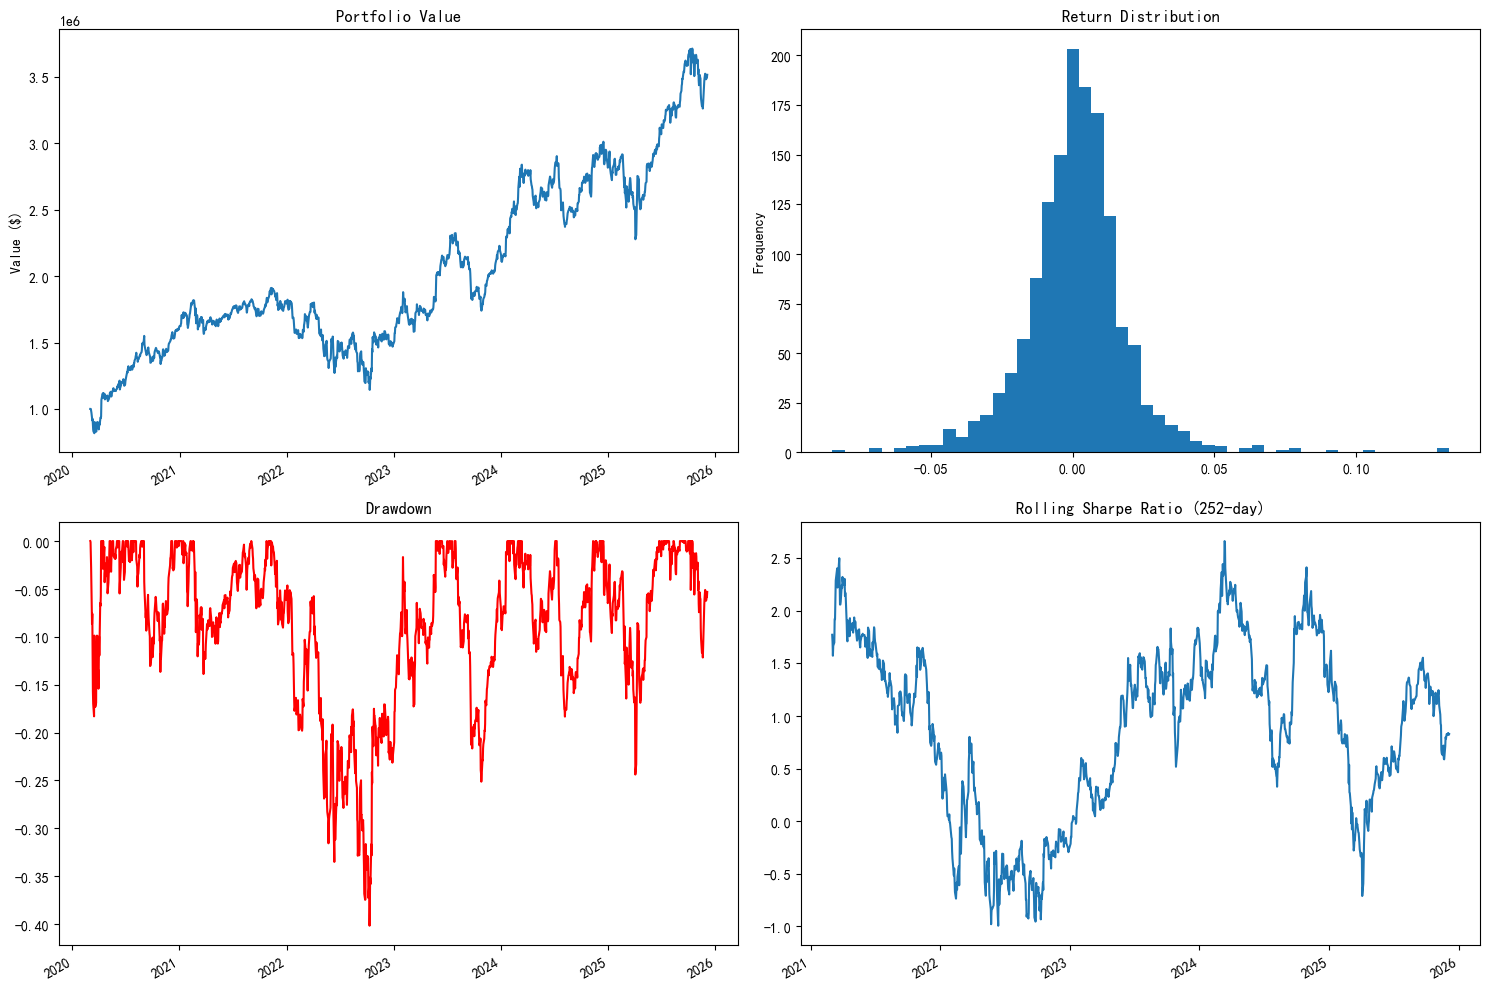

In [23]:
import matplotlib.pyplot as plt

# 设置图片大小
plt.figure(figsize=(15, 8))

# 绘制权益曲线
engine.plot_results(result)

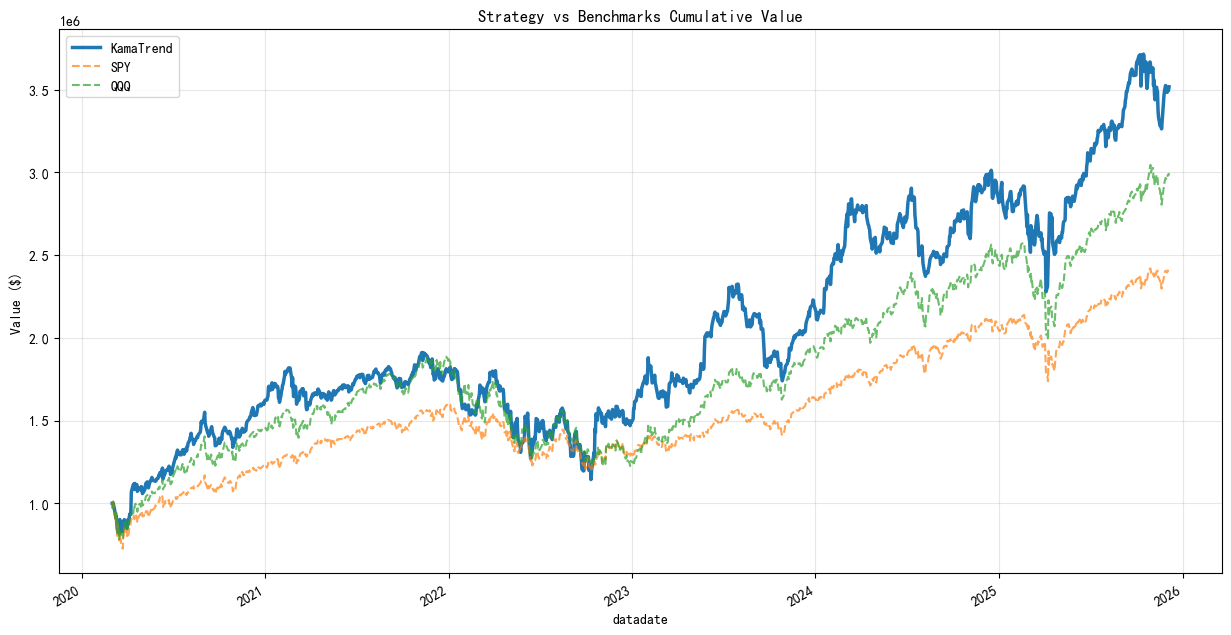

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from src.data.data_fetcher import fetch_price_data

plt.figure(figsize=(15, 8))

# 1. 绘制策略净值
# result.portfolio_values 是一个 Series，直接 plot 即可
result.portfolio_values.plot(label='KamaTrend', linewidth=2.5)

# 2. 手动拉取并绘制基准 (SPY, QQQ)
initial_value = result.portfolio_values.iloc[0]
start_date = result.portfolio_values.index.min().strftime('%Y-%m-%d')
end_date = result.portfolio_values.index.max().strftime('%Y-%m-%d')

benchmarks = ['SPY', 'QQQ']
bm_prices = fetch_price_data(benchmarks, start_date, end_date)

if not bm_prices.empty:
    # Pivot 为宽表
    bm_wide = bm_prices.pivot(index='datadate', columns='tic', values='adj_close')
    bm_wide.index = pd.to_datetime(bm_wide.index)
    
    for bm in benchmarks:
        if bm in bm_wide.columns:
            bm_series = bm_wide[bm].dropna()
            if not bm_series.empty:
                # 归一化并缩放到策略初始资金
                bm_norm = bm_series / bm_series.iloc[0] * initial_value
                bm_norm.plot(label=bm, linestyle='--', alpha=0.7)

plt.title("Strategy vs Benchmarks Cumulative Value")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# 使用 bt 库回测权重，并输出指标
import pandas as pd
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

# 读取权重

weights_path = "./log/weights_df.csv"
weights_raw = pd.read_csv(weights_path)

weights_raw['date'] = pd.to_datetime(weights_raw['date'])
    # 将 date 设置为 index，方便后续计算
weights_raw.set_index('date', inplace=True)

# 过滤全 0 的行
weight_signals = weights_raw.loc[(weights_raw.sum(axis=1) > 0.0)]
assert len(weight_signals) > 0, '权重矩阵为空，无法回测'

# 回测时间区间：覆盖权重范围并向后延申 90 天
t_start = weight_signals.index.min().strftime('%Y-%m-%d')
t_end = (weight_signals.index.max() + pd.Timedelta(days=30)).strftime('%Y-%m-%d')

cfg = BacktestConfig(
    start_date=t_start,
    end_date=t_end,
    rebalance_freq='D',
    initial_capital=1_000_000.0,
    transaction_cost=0.0
)

# 拉取价格数据
tickers_bt = weight_signals.columns.tolist()
prices_long = fetch_price_data(tickers_bt, cfg.start_date, cfg.end_date)

# 运行回测
engine = BacktestEngine(cfg)
price_data_bt = engine._prepare_price_data_for_bt(prices_long)

# 对齐权重日期到可交易日并归一化

common_cols = [c for c in weight_signals.columns if c in price_data_bt.columns]
weight_signals = weight_signals[common_cols]
trading_index = price_data_bt.index
pos = trading_index.get_indexer(weight_signals.index, method='bfill')
mask = pos != -1
weight_signals = weight_signals.iloc[mask]
weight_signals.index = trading_index[pos[mask]]

# 清洗每日无价格的股票并归一
aligned = []
for dt, row in weight_signals.iterrows():
    prices_today = price_data_bt.loc[dt, row.index]
    valid_cols = prices_today.dropna().index.tolist()
    if len(valid_cols) == 0:
        continue
    row_valid = row[valid_cols]
    s = row_valid.sum()
    if s <= 0:
        continue
    aligned.append((dt, (row_valid / s)))

if aligned:
    weight_signals = DataFrame({dt: vec for dt, vec in aligned}).T.sort_index()
else:
    raise ValueError('对齐后无有效权重行')

# 再次行归一
#weight_signals = weight_signals.div(weight_signals.sum(axis=1), axis=0).fillna(0) 
abs_sum = weight_signals.abs().sum(axis=1) #  abs().sum()
# Avoid division by zero
weight_signals = weight_signals.div(abs_sum.replace(0, 1), axis=0).fillna(0) * 0.99
result = engine.run_backtest('TSMOM Strategy', prices_long, weight_signals)
print(f"组合年化收益: {result.annualized_return:.2%}")
for bm, ann in (result.benchmark_annualized or {}).items():
    print(f"基准 {bm} 年化收益: {ann:.2%}")

metrics_df = result.to_metrics_dataframe()
metrics_df

100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


组合年化收益: 8.64%
基准 SPY 年化收益: 14.45%
基准 QQQ 年化收益: 19.21%


,annual_return,annual_volatility,annualized_return,kurtosis,max_drawdown,monthly_return,monthly_sharpe,monthly_sortino,monthly_volatility,sharpe_ratio,skewness,sortino_ratio,total_return
TSMOM Strategy,0.086419,0.078336,0.086419,-1.243111,-0.191478,0.007337,0.252244,0.452764,0.029088,1.020927,0.000528,9.044102,0.873291
SPY,0.144469,0.169767,0.144469,4.378539,-0.337151,0.012446,0.258458,0.395395,0.048154,1.052453,-2.017354,2.600995,1.778441
QQQ,0.192109,0.289427,0.192109,2.958160,-0.351191,0.016376,0.283924,0.456323,0.057679,0.887831,-1.533695,2.086878,2.783846


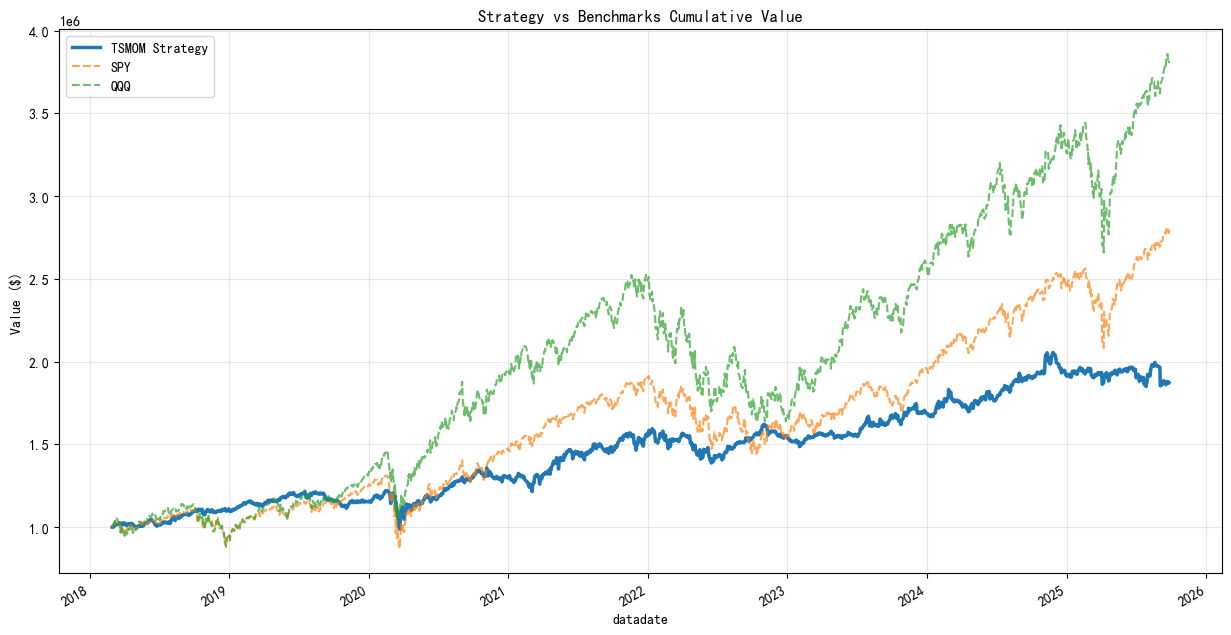

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from src.data.data_fetcher import fetch_price_data

plt.figure(figsize=(15, 8))

# 1. 绘制策略净值
# result.portfolio_values 是一个 Series，直接 plot 即可
result.portfolio_values.plot(label='TSMOM Strategy', linewidth=2.5)

# 2. 手动拉取并绘制基准 (SPY, QQQ)
initial_value = result.portfolio_values.iloc[0]
start_date = result.portfolio_values.index.min().strftime('%Y-%m-%d')
end_date = result.portfolio_values.index.max().strftime('%Y-%m-%d')

benchmarks = ['SPY', 'QQQ']
bm_prices = fetch_price_data(benchmarks, start_date, end_date)

if not bm_prices.empty:
    # Pivot 为宽表
    bm_wide = bm_prices.pivot(index='datadate', columns='tic', values='adj_close')
    bm_wide.index = pd.to_datetime(bm_wide.index)
    
    for bm in benchmarks:
        if bm in bm_wide.columns:
            bm_series = bm_wide[bm].dropna()
            if not bm_series.empty:
                # 归一化并缩放到策略初始资金
                bm_norm = bm_series / bm_series.iloc[0] * initial_value
                bm_norm.plot(label=bm, linestyle='--', alpha=0.7)

plt.title("Strategy vs Benchmarks Cumulative Value")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Asyncronize mode log split 

## one big file daily_SPX_500_feature_engineering.csv for data upload

In [20]:
import pandas as pd
import pandas_market_calendars as mcal

# === parameter configuration ===
CONFIG = {
    "price_file": "./feature/daily_SPX_500_feature_engineering.csv",
    "universe_file": "./data/stock_selected_updated.csv",
    
    "data_start_date": "2016-06-01",
    "data_end_date": "2025-07-31",
    "backtest_start_date": "2018-01-01",
    "backtest_end_date": "2025-08-31",
    
    # === 基于文件头的列名映射 ===
    "col_map": {
        # Stock Selected File Mappings
        "tic_name": "tic",
        "trade_date": "trade_date",
        
        # Price File Mappings (左: 内部标准名, 右: CSV列名)
        "datetime": "datadate",  # 日期列
        "tic": "tic",            # 股票代码
        
        # 价格字段
        "open": "prcod",         # 开盘价 (如果为空，部分逻辑可能需要 fillna)
        "high": "prchd",         # 最高价
        "low": "prcld",          # 最低价
        "close": "adj_close",    # 收盘价 (建议优先用复权后的 adj_close 计算收益)
                                 # 如果没有 adj_close，改用 "prccd"
        "volume": "cshtrd"       # 成交量
    }
}
# 获取交易日历 (NYSE)
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date="2016-01-01", end_date="2025-12-31")
trading_days = mcal.date_range(schedule, frequency='1D').normalize().tz_localize(None)

In [60]:
# load stock selected data ===
stock_selected = pd.read_csv(
    CONFIG["universe_file"],
    parse_dates=["trade_date"]
)

logger = StrategyLogger("TSMOM", async_mode=False) 


# initialize UniverseManager
uni_mgr = UniverseManager(
    stock_selection_df=stock_selected,
    col_map=CONFIG["col_map"],
    trading_calendar=trading_days,
    backtest_start=CONFIG["backtest_start_date"],
    backtest_end=CONFIG["backtest_end_date"],
    logger=logger  # 假设您已初始化 logger
)

all_tics = sorted(stock_selected["tic"].unique())
print(f"Total tickers in universe: {len(all_tics)}")

Total tickers in universe: 705


In [28]:
# initialize signal engine ===
sig_engine = KamaTrendSignalEngine(
    strategy_name="KamaTrend_SPX",
    universe_mgr=uni_mgr,
    logger=logger,
    
    # single file mode configuration
    multi_file=False,  
    chunk_size=500000,  
    
    # strategy parameters
    #lookback_months=12,
    #neutral_band=0.01,
    
    # 时间区间
    signal_start_date=CONFIG["backtest_start_date"], # 2018-01-01
    signal_end_date=CONFIG["backtest_end_date"],     # 2024-12-31
    data_start_date=CONFIG["data_start_date"],       # 2016-06-01 
    data_end_date=CONFIG["data_end_date"],
    
    col_map=CONFIG["col_map"]
)

In [29]:
# === signal generation ===
# for single file mode, the first parameter is the file path, the second parameter is the stock list (for filtering)

signal_df = sig_engine.compute_signals(
    CONFIG["price_file"], 
    all_tics
)
signal_df.to_csv("./log/signal_dffull.csv")
print("Signal DF Head:")
print(signal_df.head())
print("Signal DF Tail:")
print(signal_df.tail())


[READ] Big file in chunks: ./feature/daily_SPX_500_feature_engineering.csv
self.data_start_date: 2016-06-01 00:00:00
self.data_end_date: 2025-07-31 00:00:00
self.signal_start_date  : 2018-01-01 00:00:00
self.signal_end_date: 2025-08-31 00:00:00
262492.4434206118
self.data_start_date: 2016-06-01 00:00:00
self.data_end_date: 2025-07-31 00:00:00
self.signal_start_date  : 2018-01-01 00:00:00
self.signal_end_date: 2025-08-31 00:00:00
163684.2959543685
self.data_start_date: 2016-06-01 00:00:00
self.data_end_date: 2025-07-31 00:00:00
self.signal_start_date  : 2018-01-01 00:00:00
self.signal_end_date: 2025-08-31 00:00:00
272389.8225869624
self.data_start_date: 2016-06-01 00:00:00
self.data_end_date: 2025-07-31 00:00:00
self.signal_start_date  : 2018-01-01 00:00:00
self.signal_end_date: 2025-08-31 00:00:00
143329.08820107972
self.data_start_date: 2016-06-01 00:00:00
self.data_end_date: 2025-07-31 00:00:00
self.signal_start_date  : 2018-01-01 00:00:00
self.signal_end_date: 2025-08-31 00:00:00
18

In [34]:
exe_mgr = ExecutionManager(
    universe_mgr=uni_mgr,
    #rebalance_freq="M",
    cooling_days=0,
    logger=logger,
    max_positions=20,
    max_weight=0.20,
    #min_weight=0.05
)

weights_df = exe_mgr.generate_weight_matrix(signal_df)
weights_df.to_csv("./log/weights_df_km.csv")
print("Weights DF:")
print(weights_df.tail())
print(len(logger.signal_logs))
print(len(logger.portfolio_logs))
print(len(logger.universe_logs))

logger.close()

Weights DF:
            AAPL  AMD  AMZN  AVGO  COIN  COST  CRM  FCX  GOOGL  INTC  ...  \
date                                                                  ...   
2025-08-25   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  ...   
2025-08-26   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  ...   
2025-08-27   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  ...   
2025-08-28   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  ...   
2025-08-29   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  ...   

            NEM  NFLX  NVDA  ORCL  PEP  PYPL  SMCI  TSLA  UNH    V  
date                                                                
2025-08-25  0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0  
2025-08-26  0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0  
2025-08-27  0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0  
2025-08-28  0.0   0.0   0.0   0.0  0.0   0.0   0.0   0.0  0.0  0.0  
2025-08-29  0.0   0.0   0.0   0.0 

In [37]:
# 使用 bt 库回测权重，并输出指标
import pandas as pd
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

# 读取权重

weights_path = "./log/weights_df_km.csv"
weights_raw = pd.read_csv(weights_path)

weights_raw['date'] = pd.to_datetime(weights_raw['date'])
    # 将 date 设置为 index，方便后续计算
weights_raw.set_index('date', inplace=True)

# 过滤全 0 的行
weight_signals = weights_raw.loc[(weights_raw.sum(axis=1) > 0.0)]
assert len(weight_signals) > 0, '权重矩阵为空，无法回测'

# 回测时间区间：覆盖权重范围并向后延申 90 天
t_start = weight_signals.index.min().strftime('%Y-%m-%d')
t_end = (weight_signals.index.max() + pd.Timedelta(days=30)).strftime('%Y-%m-%d')

cfg = BacktestConfig(
    start_date=t_start,
    end_date=t_end,
    rebalance_freq='M',
    initial_capital=1_000_000.0,
    transaction_cost=0.0001

)

# 拉取价格数据
tickers_bt = weight_signals.columns.tolist()
prices_long = fetch_price_data(tickers_bt, cfg.start_date, cfg.end_date)

# 运行回测
engine = BacktestEngine(cfg)
price_data_bt = engine._prepare_price_data_for_bt(prices_long)

# 对齐权重日期到可交易日并归一化
from pandas import DataFrame
common_cols = [c for c in weight_signals.columns if c in price_data_bt.columns]
weight_signals = weight_signals[common_cols]
trading_index = price_data_bt.index
pos = trading_index.get_indexer(weight_signals.index, method='bfill')
mask = pos != -1
weight_signals = weight_signals.iloc[mask]
weight_signals.index = trading_index[pos[mask]]

# 清洗每日无价格的股票并归一
aligned = []
for dt, row in weight_signals.iterrows():
    prices_today = price_data_bt.loc[dt, row.index]
    valid_cols = prices_today.dropna().index.tolist()
    if len(valid_cols) == 0:
        continue
    row_valid = row[valid_cols]
    s = row_valid.sum()
    if s <= 0:
        continue
    aligned.append((dt, (row_valid / s)))

if aligned:
    weight_signals = DataFrame({dt: vec for dt, vec in aligned}).T.sort_index()
else:
    raise ValueError('对齐后无有效权重行')

# 再次行归一
# 绝对值归一化 (L/S 策略)
abs_sum = weight_signals.abs().sum(axis=1)
weight_signals = weight_signals.div(abs_sum, axis=0).fillna(0)
#weight_signals = weight_signals.div(weight_signals.sum(axis=1), axis=0).fillna(0)

result = engine.run_backtest('TSMOM Strategy', prices_long, weight_signals)
print(f"组合年化收益: {result.annualized_return:.2%}")
for bm, ann in (result.benchmark_annualized or {}).items():
    print(f"基准 {bm} 年化收益: {ann:.2%}")

metrics_df = result.to_metrics_dataframe()
metrics_df

100%|██████████| 1/1 [00:00<00:00, 23.13it/s]

组合年化收益: 18.54%
基准 SPY 年化收益: 16.66%
基准 QQQ 年化收益: 20.77%


,annual_return,annual_volatility,annualized_return,kurtosis,max_drawdown,monthly_return,monthly_sharpe,monthly_sortino,monthly_volatility,sharpe_ratio,skewness,sortino_ratio,total_return
TSMOM Strategy,0.185412,0.311462,0.185412,-0.139486,-0.473027,0.018353,0.198989,0.372597,0.092230,0.442507,0.176043,1.251697,1.545071
SPY,0.166575,0.195468,0.166575,2.335313,-0.283149,0.014178,0.279451,0.436671,0.050734,0.740039,-1.628481,1.779782,1.330737
QQQ,0.207652,0.320084,0.207652,1.799203,-0.351176,0.017665,0.288668,0.476105,0.061196,0.544451,-0.905142,1.196203,1.818615


<Figure size 1500x800 with 0 Axes>

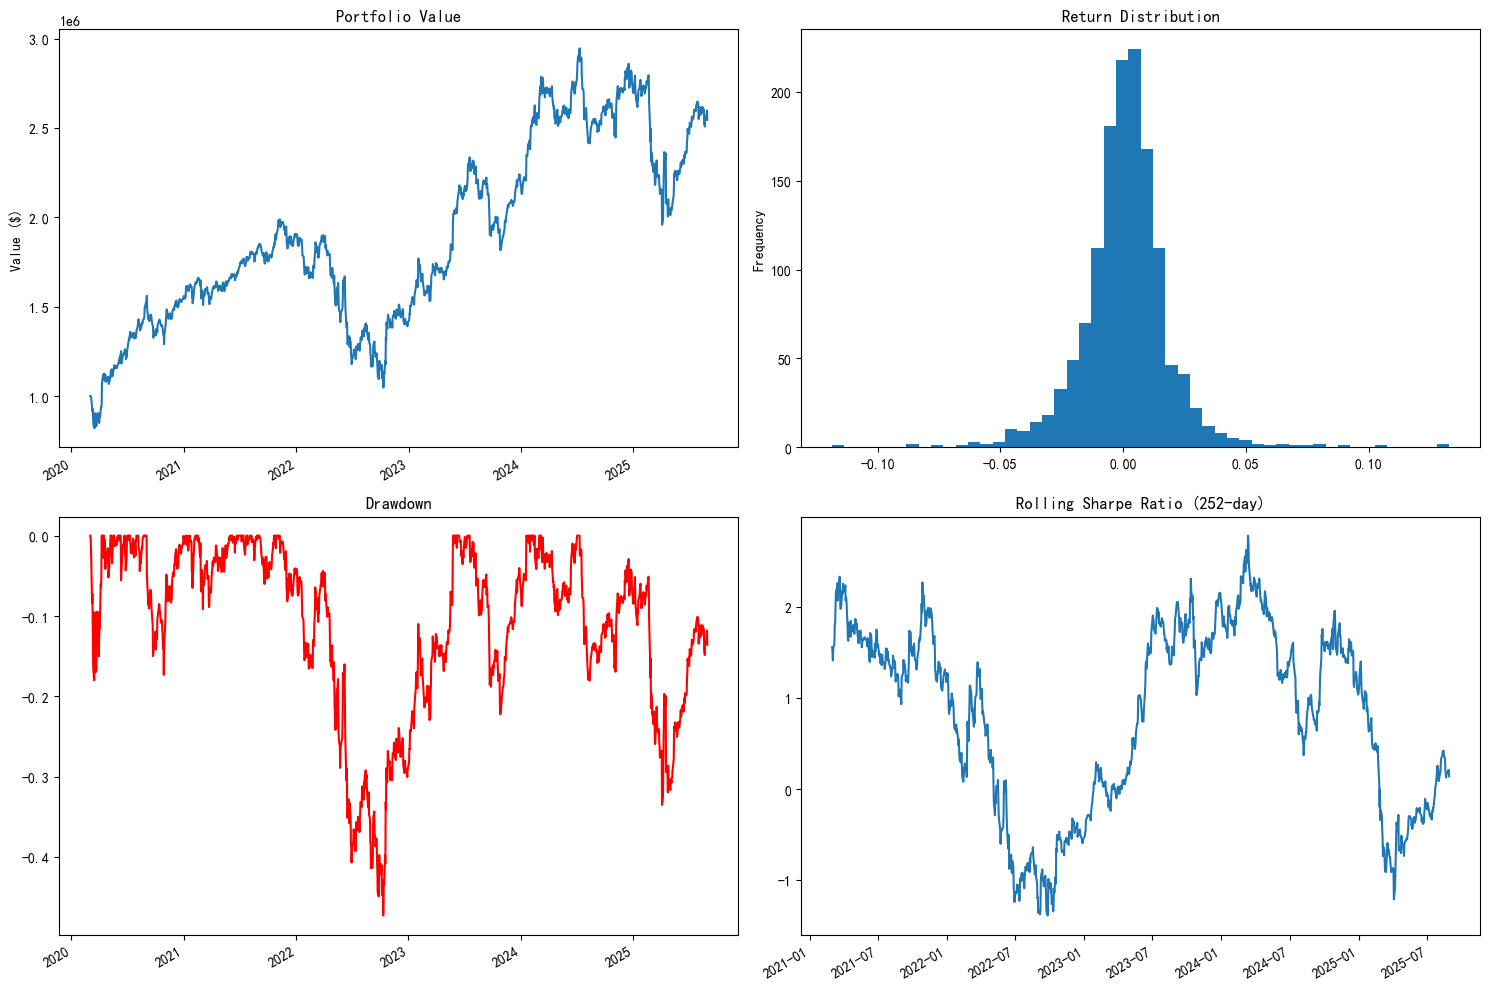

In [38]:
import matplotlib.pyplot as plt

# 设置图片大小
plt.figure(figsize=(15, 8))

# 绘制权益曲线
engine.plot_results(result)

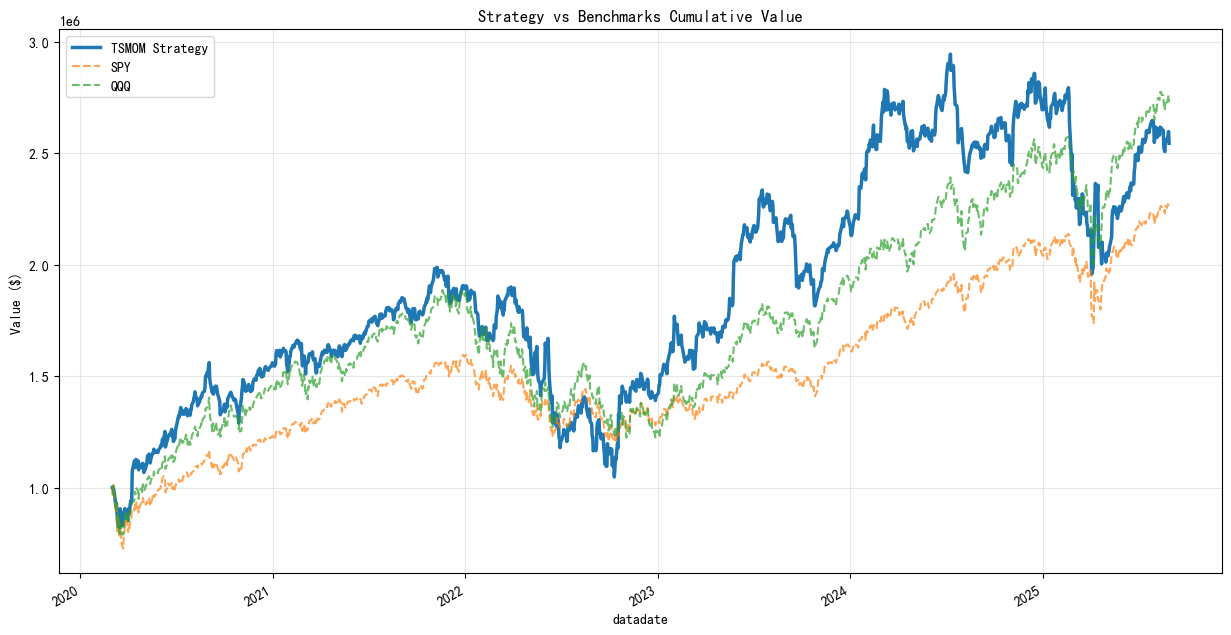

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from src.data.data_fetcher import fetch_price_data

plt.figure(figsize=(15, 8))

# 1. 绘制策略净值
# result.portfolio_values 是一个 Series，直接 plot 即可
result.portfolio_values.plot(label='TSMOM Strategy', linewidth=2.5)

# 2. 手动拉取并绘制基准 (SPY, QQQ)
initial_value = result.portfolio_values.iloc[0]
start_date = result.portfolio_values.index.min().strftime('%Y-%m-%d')
end_date = result.portfolio_values.index.max().strftime('%Y-%m-%d')

benchmarks = ['SPY', 'QQQ']
bm_prices = fetch_price_data(benchmarks, start_date, end_date)

if not bm_prices.empty:
    # Pivot 为宽表
    bm_wide = bm_prices.pivot(index='datadate', columns='tic', values='adj_close')
    bm_wide.index = pd.to_datetime(bm_wide.index)
    
    for bm in benchmarks:
        if bm in bm_wide.columns:
            bm_series = bm_wide[bm].dropna()
            if not bm_series.empty:
                # 归一化并缩放到策略初始资金
                bm_norm = bm_series / bm_series.iloc[0] * initial_value
                bm_norm.plot(label=bm, linestyle='--', alpha=0.7)

plt.title("Strategy vs Benchmarks Cumulative Value")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
import pandas as pd
import numpy as np
from src.data.data_fetcher import fetch_price_data

# ==========================================
# 1. 定义指标计算函数
# ==========================================
def calculate_metrics(daily_returns, risk_free_rate=0.0):
    """计算单组收益率序列的核心指标"""
    if len(daily_returns) == 0:
        return pd.Series(dtype=float)
    
    # 累计收益 (Total Return)
    total_return = (1 + daily_returns).prod() - 1
    
    # 年化收益 (CAGR)
    # 如果是计算单年指标，且这一年完整，CAGR ≈ Total Return
    # 为了通用性，我们还是用天数年化
    days = len(daily_returns)
    if days > 0:
        annual_return = (1 + total_return) ** (252 / days) - 1
    else:
        annual_return = 0.0
        
    # 年化波动率
    daily_vol = daily_returns.std()
    annual_vol = daily_vol * np.sqrt(252)
    
    # 最大回撤
    cum_returns = (1 + daily_returns).cumprod()
    drawdown = cum_returns / cum_returns.cummax() - 1
    max_drawdown = drawdown.min()
    
    # 夏普比率 (Sharpe Ratio)
    if annual_vol > 0:
        sharpe = (daily_returns.mean() * 252 - risk_free_rate) / annual_vol
    else:
        sharpe = np.nan
        
    # 索提诺比率 (Sortino Ratio)
    downside_returns = daily_returns[daily_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    if downside_std > 0:
        sortino = (daily_returns.mean() * 252 - risk_free_rate) / downside_std
    else:
        sortino = np.nan
        
    # 峰度 (Kurtosis)
    kurtosis = daily_returns.kurt()
    
    return pd.Series({
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': annual_vol,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Kurtosis': kurtosis
    })

# ==========================================
# 2. 准备数据
# ==========================================
# 2.1 Portfolio Returns
pf_returns = result.portfolio_returns

# 2.2 Fetch Benchmark Returns (SPY, QQQ)
# 注意：我们需要和 Portfolio 的时间段完全一致
start_date = pf_returns.index.min().strftime('%Y-%m-%d')
end_date = pf_returns.index.max().strftime('%Y-%m-%d')
benchmarks = ['SPY', 'QQQ']
bm_data = fetch_price_data(benchmarks, start_date, end_date)

bm_returns_dict = {}
if not bm_data.empty:
    bm_wide = bm_data.pivot(index='datadate', columns='tic', values='adj_close')
    bm_wide.index = pd.to_datetime(bm_wide.index)
    for bm in benchmarks:
        if bm in bm_wide.columns:
            # 计算日收益率并对齐到策略日期
            r = bm_wide[bm].pct_change().dropna()
            # 取交集，确保日期一致，方便对比
            common_idx = r.index.intersection(pf_returns.index)
            bm_returns_dict[bm] = r.loc[common_idx]

# 将所有收益率合并到一个 DataFrame
all_returns = pd.DataFrame({'Portfolio': pf_returns})
for bm, r in bm_returns_dict.items():
    all_returns[bm] = r

# ==========================================
# 3. 计算年度对比表格
# ==========================================
yearly_stats = []
years = all_returns.index.year.unique().sort_values()

for year in years:
    year_data = all_returns[all_returns.index.year == year]
    
    for col in year_data.columns:
        metrics = calculate_metrics(year_data[col])
        metrics['Year'] = year
        metrics['Strategy'] = col
        yearly_stats.append(metrics)

yearly_df = pd.DataFrame(yearly_stats)
# 设置多级索引 (Year, Strategy) 方便查看
yearly_comparison = yearly_df.set_index(['Year', 'Strategy'])

print("\n========== Yearly Performance Comparison ==========")
# 格式化显示
format_mapping = {
    'Total Return': '{:.2%}',
    'Annual Return': '{:.2%}',
    'Volatility': '{:.2%}',
    'Max Drawdown': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Sortino Ratio': '{:.2f}',
    'Kurtosis': '{:.2f}'
}
print(yearly_comparison.style.format(format_mapping).to_string())


# ==========================================
# 4. 计算 Overall (全样本) 对比表格
# ==========================================
overall_stats = []
for col in all_returns.columns:
    # 这里要注意：全样本计算时需要剔除 NaN（如果有的话，虽然之前已经做了交集）
    valid_ret = all_returns[col].dropna()
    metrics = calculate_metrics(valid_ret)
    metrics['Strategy'] = col
    overall_stats.append(metrics)

overall_df = pd.DataFrame(overall_stats).set_index('Strategy')

print("\n========== Overall Performance Comparison ==========")
print(overall_df.style.format(format_mapping).to_string())

# 如果需要导出到 CSV
yearly_comparison.to_csv('yearly_comparison.csv')
overall_df.to_csv('overall_comparison.csv')


========== Yearly Performance Comparison ==========
  Total Return Annual Return Volatility Max Drawdown Sharpe Ratio Sortino Ratio Kurtosis
Year Strategy       
2020.000000 Portfolio 55.99% 69.64% 34.18% -18.02% 1.72 2.55 8.53
SPY 26.85% 32.68% 35.10% -28.32% 0.99 1.10 7.02
QQQ 50.85% 63.01% 37.12% -22.41% 1.51 1.73 5.75
2021.000000 Portfolio 21.30% 21.30% 17.76% -9.15% 1.18 1.64 1.37
SPY 28.73% 28.73% 12.99% -5.11% 2.01 2.87 0.67
QQQ 27.42% 27.42% 18.22% -10.85% 1.42 2.02 0.91
2022.000000 Portfolio -25.42% -25.50% 39.88% -45.01% -0.54 -0.88 4.08
SPY -18.18% -18.24% 24.24% -24.50% -0.71 -1.14 0.36
QQQ -32.58% -32.68% 32.15% -34.83% -1.07 -1.77 0.17
2023.000000 Portfolio 56.75% 57.31% 22.83% -22.25% 2.10 3.31 1.76
SPY 26.18% 26.41% 13.08% -9.98% 1.86 3.07 -0.16
QQQ 54.86% 55.40% 17.86% -10.78% 2.56 4.45 -0.13
2024.000000 Portfolio 21.88% 21.88% 20.91% -18.06% 1.05 1.64 1.99
SPY 24.89% 24.89% 12.57% -8.41% 1.83 2.40 1.80
QQQ 25.58% 25.58% 18.01% -13.56% 1.36 1.84 0.94
2025.000000 Portf

In [43]:
# 1. 检查 Portfolio 的日期覆盖范围
print("Portfolio Start:", result.portfolio_returns.index.min())
print("Portfolio End:  ", result.portfolio_returns.index.max())
print("Portfolio Days: ", len(result.portfolio_returns))

# 2. 检查基准数据的原始范围（未对齐前）
raw_qqq = fetch_price_data(['QQQ'], start_date, end_date)
if not raw_qqq.empty:
    print("\nRaw QQQ Data Points:", len(raw_qqq))
    print("Raw QQQ Start:", raw_qqq['datadate'].min())
    print("Raw QQQ End:  ", raw_qqq['datadate'].max())
    
    # 计算原始 QQQ 在此期间的真实收益
    q_prices = raw_qqq.sort_values('datadate')['adj_close'].values
    real_return = (q_prices[-1] / q_prices[0]) - 1
    print(f"Raw QQQ Return (from prices): {real_return:.4%}")

# 3. 检查对齐后的数据
if 'QQQ' in bm_returns_dict:
    aligned_qqq = bm_returns_dict['QQQ']
    print(f"\nAligned QQQ Days: {len(aligned_qqq)}")
    aligned_return = (1 + aligned_qqq).prod() - 1
    print(f"Aligned QQQ Return (calculated): {aligned_return:.4%}")
    
    # 检查是否有大段日期缺失
    diff = aligned_qqq.index.to_series().diff().dt.days
    gaps = diff[diff > 4] # 超过4天的间隔（排除周末）
    if not gaps.empty:
        print("\nPossible Data Gaps in Alignment:")
        print(gaps)

Portfolio Start: 2020-03-03 00:00:00
Portfolio End:   2025-08-29 00:00:00
Portfolio Days:  1382

Raw QQQ Data Points: 1382
Raw QQQ Start: 2020-03-03
Raw QQQ End:   2025-08-29
Raw QQQ Return (from prices): 181.9099%

Aligned QQQ Days: 1381
Aligned QQQ Return (calculated): 181.9099%


In [44]:
from src.data.data_fetcher import FMPFetcher
from datetime import datetime
import pandas as pd
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

t_start = "2025-01-01"
t_end = datetime.today().strftime("%Y-%m-%d")

fetcher = FMPFetcher()
prices_long = fetcher.get_price_data(
    tickers=pd.DataFrame({'tickers': weights_raw.columns}),
    start_date=t_start,
    end_date=t_end
)
# 保留关键列
prices_long = prices_long[['datadate', 'tic', 'adj_close']]
prices_long.rename(columns={'datadate': 'date'}, inplace=True)
prices_long['date'] = pd.to_datetime(prices_long['date'])

FMP API key: **********


In [45]:
import pandas as pd

def compute_trade_winrate(weights_df, prices_long):
    results = []

    for tic in weights_df.columns:
        w = weights_df[tic]
        if (w.abs().sum() == 0):
            continue

        p = prices_long[prices_long['tic'] == tic].set_index('date')['adj_close'].sort_index()

        # 识别仓位变化点
        prev_pos = 0
        open_date = None
        open_price = None
        pos_type = None  # 1 for long, -1 for short
        trades = []

        for date, val in w.items():
            pos = 1 if val > 0 else -1 if val < 0 else 0

            # 开仓
            if prev_pos == 0 and pos != 0:
                open_date = date
                open_price = p.loc[p.index <= date].iloc[-1] if len(p.loc[p.index <= date]) else None
                pos_type = pos

            # 平仓
            elif prev_pos != 0 and pos == 0:
                if open_date and open_price and len(p.loc[p.index <= date]) > 0:
                    close_price = p.loc[p.index <= date].iloc[-1]
                    ret = (close_price / open_price - 1) * pos_type  # long正，short反
                    trades.append({'tic': tic, 'type': 'long' if pos_type == 1 else 'short',
                                   'open': open_date, 'close': date, 'ret': ret})
                open_date = None
                open_price = None
                pos_type = None

            prev_pos = pos

        # 汇总胜率
        if trades:
            df = pd.DataFrame(trades)
            long_trades = df[df['type'] == 'long']
            short_trades = df[df['type'] == 'short']
            res = {
                'tic': tic,
                'long_trades': len(long_trades),
                'long_win_rate': (long_trades['ret'] > 0).mean() if len(long_trades) else None,
                'short_trades': len(short_trades),
                'short_win_rate': (short_trades['ret'] > 0).mean() if len(short_trades) else None
            }
            results.append(res)

    res_df = pd.DataFrame(results)
    res_df['long_win_rate'] = res_df['long_win_rate'] * 100
    res_df['short_win_rate'] = res_df['short_win_rate'] * 100
    res_df = res_df.fillna(0)
    return res_df


In [46]:
trade_stats = compute_trade_winrate(weights_raw, prices_long)
summary = pd.DataFrame({
    'Average Long WinRate (%)': [trade_stats['long_win_rate'].mean()],
    'Average Short WinRate (%)': [trade_stats['short_win_rate'].mean()]
})
print(trade_stats)
print(summary)


      tic  long_trades  long_win_rate  short_trades  short_win_rate
0    AAPL            1       0.000000             0               0
1     AMD            3      66.666667             0               0
2    AMZN            2     100.000000             0               0
3    AVGO            7      28.571429             0               0
4    COIN            4      50.000000             0               0
5    COST            6       0.000000             0               0
6     CRM            1       0.000000             0               0
7     FCX            3      33.333333             0               0
8   GOOGL            3      66.666667             0               0
9    INTC            4       0.000000             0               0
10    JPM            3     100.000000             0               0
11   META            6      33.333333             0               0
12   MSFT            2     100.000000             0               0
13    NEM            6      66.666667           